In [11]:
import pandas as pd
import numpy as np
import os, random
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense,GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.applications import InceptionV3
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import Adam, RMSprop, SGD
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import time
from IPython.display import Image


In [12]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3)) 

for layer in base_model.layers:
    layer.trainable = False

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024, activation='relu')(x) #dense layer 1
x = Dropout(0.5)(x)
x=Dense(512, activation='relu')(x) #dense layer 2
x = Dropout(0.3)(x)
x=Dense(256, activation='relu')(x) #dense layer 3
x=Dense(100, activation='relu')(x)
preds=Dense(3, activation='softmax')(x) #final layer with softmax activation

model=Model(inputs=base_model.input, outputs=preds)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [13]:
root_dir = './'
dataset_dir = os.path.join(root_dir, 'dataset_n')
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input) #included in our dependencies

train_generator = train_datagen.flow_from_directory(train_dir, # this is where you specify the path to the main data folder
                                                 target_size=(299, 299),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 seed=123,
                                                 shuffle=True)

class_names = list(train_generator.class_indices.keys())
print(class_names)
# print(train_generator.)

Found 9592 images belonging to 3 classes.
['Alaskan_Malamute', 'Shiba_Inu', 'Siberian_Husky']


In [14]:
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

val_generator = val_datagen.flow_from_directory( val_dir, # this is where you specify the path to the main data folder
                                                 target_size=(299, 299),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 seed = 123,
                                                 shuffle=True)

Found 3198 images belonging to 3 classes.


In [15]:
learning_rate = 0.001
# RMSprop(lr=learning_rate, rho=0.9)
# SGD(lr=learning_rate, nesterov=True)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

# random labels_dict
labels_dict = {0: 5200, 1: 1800, 2: 5200}

class_weight = create_class_weight(labels_dict)
# print(class_weight)

epochs = 45
step_size_train = train_generator.n // train_generator.batch_size
start = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    steps_per_epoch=step_size_train,
                    class_weight={0: 1, 1: 3, 2: 1},
                    epochs = epochs)
end = time.time()

Epoch 1/45
299/299 [==============================] - 49s 153ms/step - loss: 0.9054 - accuracy: 0.6651 - val_loss: 0.3923 - val_accuracy: 0.8252
Epoch 2/45
299/299 [==============================] - 42s 141ms/step - loss: 0.5201 - accuracy: 0.8018 - val_loss: 0.3743 - val_accuracy: 0.8424
Epoch 3/45
299/299 [==============================] - 42s 142ms/step - loss: 0.4549 - accuracy: 0.8251 - val_loss: 0.3809 - val_accuracy: 0.8086
Epoch 4/45
299/299 [==============================] - 42s 141ms/step - loss: 0.4065 - accuracy: 0.8377 - val_loss: 0.3507 - val_accuracy: 0.8480
Epoch 5/45
299/299 [==============================] - 42s 142ms/step - loss: 0.3808 - accuracy: 0.8444 - val_loss: 0.3648 - val_accuracy: 0.8311
Epoch 6/45
299/299 [==============================] - 44s 148ms/step - loss: 0.3581 - accuracy: 0.8457 - val_loss: 0.3485 - val_accuracy: 0.8446
Epoch 7/45
299/299 [==============================] - 46s 153ms/step - loss: 0.3623 - accuracy: 0.8572 - val_loss: 0.3638 - val_ac

In [17]:
training_time = end-start
print(f'Traning time (s) : {training_time}')

Traning time (s) : 1960.9452157020569


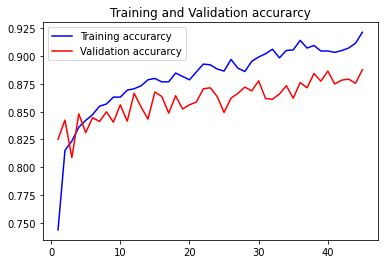

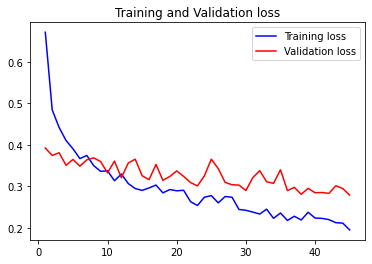

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Save Model

In [19]:
model_path = os.path.join(root_dir, 'saved-model', 'dog-breed-inceptionV3-KARN-Adam-OLD.h5')
model.save(model_path)

Test Model

In [20]:
# # path = "./dataset/test/maxresdefault.jpg"
# path = './dataset_n/test/' + random.choice(os.listdir('./dataset_n/test/'))

# display(Image(filename=path))
# img = image.load_img(path, color_mode ='rgb',target_size = (299, 299))
# img = image.img_to_array(img)
# img = np.expand_dims(img, axis = 0)
# img = preprocess_input(img)
# score = model.predict(img)

# print(score)
# print(
# "This image most likely belongs to {} with a {:.2f} percent confidence."
# .format(class_names[np.argmax(score)], 100 * np.max(score))
# )

In [24]:
model = load_model(os.path.join(root_dir, 'saved-model', 'dog-breed-inceptionV3-KARN-Adam-2.h5'))

In [25]:
test_dir = os.path.join(dataset_dir, "test")
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (299, 299),
                                            batch_size = 32,
                                            class_mode = 'categorical')

score = model.evaluate(test_set)
print('Test Accuracy:', score[1])
print('Test Loss:', score[0])

Found 200 images belonging to 3 classes.
7/7 [==============================] - 2s 162ms/step - loss: 0.3114 - accuracy: 0.9100
Test Accuracy: 0.9100000262260437
Test Loss: 0.3113895356655121


In [26]:
total_img = 0
correct_predictions = 0

for folder_name in os.listdir(test_dir):
  folder_path = os.path.join(test_dir, folder_name)
  for image_name in os.listdir(folder_path):
    test_image = image.load_img(os.path.join(folder_path, image_name), color_mode ='rgb',target_size = (299, 299))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    test_image = preprocess_input(test_image)
    result = model.predict(test_image)
    res = np.argmax(result)
    label_name = {0 : 'Alaskan_Malamute', 1: 'Shiba_Inu', 2: 'Siberian_Husky'} #'Alaskan_Malamute', 'Shiba_Inu', 'Siberian_Husky'
    predicted_class = label_name[res]
    if predicted_class != folder_name:
      print("The predicted output is :", predicted_class, "Correct output is", folder_name)
    if predicted_class == folder_name:
      correct_predictions = correct_predictions + 1   
    total_img = total_img + 1

print("******* Benchmark Results **********")
print(f'Total image is {total_img}')
print(f'Total correct predictions is {correct_predictions}')
print(f'Total incorrect predictions is {total_img - correct_predictions}')

The predicted output is : Siberian_Husky Correct output is Alaskan_Malamute
The predicted output is : Siberian_Husky Correct output is Alaskan_Malamute
The predicted output is : Shiba_Inu Correct output is Alaskan_Malamute
The predicted output is : Shiba_Inu Correct output is Siberian_Husky
The predicted output is : Alaskan_Malamute Correct output is Siberian_Husky
The predicted output is : Alaskan_Malamute Correct output is Siberian_Husky
The predicted output is : Alaskan_Malamute Correct output is Siberian_Husky
The predicted output is : Alaskan_Malamute Correct output is Siberian_Husky
The predicted output is : Alaskan_Malamute Correct output is Siberian_Husky
The predicted output is : Alaskan_Malamute Correct output is Siberian_Husky
The predicted output is : Alaskan_Malamute Correct output is Siberian_Husky
The predicted output is : Alaskan_Malamute Correct output is Siberian_Husky
The predicted output is : Alaskan_Malamute Correct output is Siberian_Husky
The predicted output is 